In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import wilcoxon
import scipy.stats as stats
from datetime import datetime, timedelta

In [9]:
# Pfad zu den Daten und Definition der Monatsbezeichnungen
DATA_PATH = '/Users/bugragorkem/Desktop/Uni/5. Semester /Data Science Projekt/archive/p_data/p_einzelnt/'
MONTHS = ["p01", "p02", "p03", "p04", "p05", "p06", "p07", "p08", "p09", "p10", "p11", "p12"]

In [10]:
# Funktion zur Zuordnung von HOV-Sensoren (für die erste Filterung)
def find_closest_sensor(incidence_df, sensor_df, max_distance=0.3):
    # Sortiere die Sensoren nach 'Fwy' und 'Abs PM'
    sensor_df = sensor_df.sort_values(by=['Fwy', 'Abs PM'])
    closest_sensors = []
    for _, incident in incidence_df.iterrows():
        fwy = incident['Fwy']
        abs_pm = incident['Abs PM']
        # Filtere Sensoren des Typs "HOV" auf demselben Freeway
        matching_sensors = sensor_df[(sensor_df['Fwy'] == fwy) & (sensor_df['Type'] == 'HOV')]
        # Wähle den Sensor, der unmittelbar vor dem Unfall liegt und innerhalb von max_distance liegt
        preceding_sensors = matching_sensors[
            (matching_sensors['Abs PM'] <= abs_pm) & 
            ((abs_pm - matching_sensors['Abs PM']) <= max_distance)
        ]
        if not preceding_sensors.empty:
            closest_sensor = preceding_sensors.iloc[-1]
            closest_sensors.append({
                'Incident_ABS_PM': abs_pm,
                'Incident_Fwy': fwy,
                'station_id': closest_sensor['station_id'],
                'Sensor_ABS_PM': closest_sensor['Abs PM'],
                'Sensor_Fwy': closest_sensor['Fwy'],
                'time': incident['dt'],
                'Distance': abs_pm - closest_sensor['Abs PM']
            })
    return pd.DataFrame(closest_sensors)



In [11]:
# Funktion zur Zuordnung von Mainline-Sensoren zu den bereits gefilterten Unfällen
def find_closest_mainline_sensor(incidence_df, sensor_df, max_distance=0.3):
    sensor_df = sensor_df.sort_values(by=['Fwy', 'Abs PM'])
    assigned_sensors = []
    for _, incident in incidence_df.iterrows():
        fwy = incident['Incident_Fwy']
        # Hier verwenden wir den Unfallort (Incident_ABS_PM) aus der HOV-Zuordnung
        abs_pm = incident['Incident_ABS_PM']
        # Filtere Sensoren des Typs "Mainline" auf demselben Freeway
        matching_sensors = sensor_df[(sensor_df['Fwy'] == fwy) & (sensor_df['Type'] == 'Mainline')]
        preceding_sensors = matching_sensors[
            (matching_sensors['Abs PM'] <= abs_pm) &
            ((abs_pm - matching_sensors['Abs PM']) <= max_distance)
        ]
        if not preceding_sensors.empty:
            closest_sensor = preceding_sensors.iloc[-1]
            assigned_sensors.append({
                'Incident_ABS_PM': abs_pm,
                'Incident_Fwy': fwy,
                'station_id': closest_sensor['station_id'],
                'Sensor_ABS_PM': closest_sensor['Abs PM'],
                'Sensor_Fwy': closest_sensor['Fwy'],
                'time': incident['time'],  # Unfallzeit bleibt gleich
                'Distance': abs_pm - closest_sensor['Abs PM']
            })
    return pd.DataFrame(assigned_sensors)

In [12]:
# Hilfsfunktion zur Umrechnung von datetime in Timeslot-Index (Intervall: 5 Minuten)
def datetime_to_timeslot(dt, month_start):
    delta = dt - month_start
    return int(delta.total_seconds() // 300)

In [6]:
# Lade die Unfalldaten und filtere diese
incidents = pd.read_csv('/Users/bugragorkem/Desktop/Uni/5. Semester /Data Science Projekt/archive/incidents.csv', 
                        sep="\t", parse_dates=['dt'])
incidents['month'] = incidents['dt'].dt.to_period('M')

# Filter: Nur Unfälle des Typs "accident" mit einer Dauer >= 15 Minuten
incidents = incidents[(incidents['type'] == "accident") & (incidents['Duration (mins)'] >= 15)]

In [7]:
# Lade Sensor-Metadaten
sensor_meta = pd.read_csv('/Users/bugragorkem/Desktop/Uni/5. Semester /Data Science Projekt/archive/sensor_meta_feature.csv', sep="\t")


In [8]:
# 1. Filtere Unfälle, die in der Nähe eines HOV-Sensors liegen
hov_incidents = find_closest_sensor(incidents, sensor_meta)
print("Anzahl der HOV-Unfälle:", len(hov_incidents))

Anzahl der HOV-Unfälle: 20789


In [9]:
# 2. Weise diesen HOV-Unfällen Mainline-Sensoren zu (dafür filtern wir die Sensor-Metadaten)
mainline_sensor_meta = sensor_meta[sensor_meta['Type'] == 'Mainline']
mainline_incidents = find_closest_mainline_sensor(hov_incidents, mainline_sensor_meta)
print("Anzahl der Unfälle mit zugeordnetem Mainline-Sensor:", len(mainline_incidents))
mainline_incidents.to_csv("mainline_incidents.csv", index=False)

Anzahl der Unfälle mit zugeordnetem Mainline-Sensor: 20317


In [13]:
mainline_incidents = pd.read_csv("mainline_incidents.csv")

In [14]:
congestion_results = []

for idx, row in mainline_incidents.iterrows():
    # Korrigiere den Unfallzeitpunkt um 5 Minuten zurück (wie zuvor)
    accident_time = pd.to_datetime(row['time']) - pd.Timedelta(minutes=5)
    # Bestimme Monat und Dateinamen
    month = accident_time.to_period('M')
    month_str = f"p{month.month:02d}"
    
    try:
        # Lade die Geschwindigkeitsdaten als Memory-Mapped Array
        speed_data = np.load(os.path.join(DATA_PATH, f'{month_str}_speed.npy'), mmap_mode='r')
        station_ids = np.load(os.path.join(DATA_PATH, f'{month_str}_speed_node.npy')).astype(str)
    except FileNotFoundError:
        print(f"Speed data files for {month_str} not found. Überspringe Unfall {idx}.")
        continue

    sensor_id = str(row['station_id'])
    if sensor_id not in station_ids:
        print(f"Sensor {sensor_id} nicht in den Speed-Daten gefunden. Überspringe Unfall {idx}.")
        continue
    sensor_idx = np.where(station_ids == sensor_id)[0][0]
    
    # Bestimme den Timeslot relativ zum Monatsanfang
    month_start = datetime(accident_time.year, accident_time.month, 1)
    timeslot = datetime_to_timeslot(accident_time, month_start)
    
    # Definiere das 15-Minuten-Fenster (3 Intervalle à 5 Minuten)
    start_slot = timeslot
    end_slot = timeslot + 3
    if end_slot > speed_data.shape[0]:
        end_slot = speed_data.shape[0]
    
    # Extrahiere nur den benötigten Slice; dank Memory Mapping werden nur die relevanten Daten geladen
    speed_slice = speed_data[start_slot:end_slot, sensor_idx]
    
    # Prüfe, ob innerhalb des Fensters ein Wert < 35 vorliegt (Stau)
    congestion = np.any(speed_slice < 35)
    
    # Optional: statt des gesamten speed_slice speichern wir nur den Minimalwert, um Speicher zu sparen
    min_speed = np.min(speed_slice)
    
    congestion_results.append({
        'accident_time': accident_time,
        'station_id': sensor_id,
        'min_speed': min_speed,   # Zusammenfassung des Slice (statt des ganzen Arrays)
        'congestion': congestion
    })

# Zusammenfassung der Ergebnisse
num_accidents = len(congestion_results)
num_congestion = sum(1 for r in congestion_results if r['congestion'])
print(f"Von {num_accidents} Unfällen mit Mainline-Sensorzuordnung weisen {num_congestion} einen Stau auf (Geschwindigkeit < 35 innerhalb von 15 Minuten).")


Sensor 801255 nicht in den Speed-Daten gefunden. Überspringe Unfall 0.
Sensor 717155 nicht in den Speed-Daten gefunden. Überspringe Unfall 1.
Sensor 801255 nicht in den Speed-Daten gefunden. Überspringe Unfall 3.
Sensor 801255 nicht in den Speed-Daten gefunden. Überspringe Unfall 4.
Sensor 717152 nicht in den Speed-Daten gefunden. Überspringe Unfall 7.
Sensor 801237 nicht in den Speed-Daten gefunden. Überspringe Unfall 9.
Sensor 801255 nicht in den Speed-Daten gefunden. Überspringe Unfall 11.
Sensor 801232 nicht in den Speed-Daten gefunden. Überspringe Unfall 12.
Sensor 717155 nicht in den Speed-Daten gefunden. Überspringe Unfall 13.
Sensor 801232 nicht in den Speed-Daten gefunden. Überspringe Unfall 16.
Sensor 801237 nicht in den Speed-Daten gefunden. Überspringe Unfall 17.
Sensor 716069 nicht in den Speed-Daten gefunden. Überspringe Unfall 26.
Sensor 716069 nicht in den Speed-Daten gefunden. Überspringe Unfall 30.
Sensor 801289 nicht in den Speed-Daten gefunden. Überspringe Unfall 34

In [16]:
# ... (vorheriger Code, in dem congestion_results erstellt wird)

# Ausgabe der Zusammenfassung
num_accidents = len(congestion_results)
num_congestion = sum(1 for r in congestion_results if r['congestion'])
print(f"Von {num_accidents} Unfällen mit Mainline-Sensorzuordnung weisen {num_congestion} einen Stau auf (Geschwindigkeit < 35 innerhalb von 15 Minuten).")

# ---------------------------------------------------------
# Hier beginnt der neue Code zum Erstellen und Speichern des DataFrames

# Erstelle ein DataFrame aus der Liste der Ergebnisse
congestion_df = pd.DataFrame(congestion_results)

# Filtere nur die Unfälle, bei denen ein Stau vorliegt (congestion == True)
congestion_accidents_df = congestion_df[congestion_df['congestion'] == True]

# Optional: Überblick ausgeben
print("Anzahl der Unfälle mit Stau:", len(congestion_accidents_df))
print(congestion_accidents_df.head())

# Erstelle den Ausgabeordner, falls nicht vorhanden
output_path = '/Users/bugragorkem/Desktop/Uni/5. Semester /Data Science Projekt/results/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Speichere das DataFrame als CSV-Datei
congestion_accidents_df.to_csv(os.path.join(output_path, 'accidents_with_congestion.csv'), index=False)


Von 10753 Unfällen mit Mainline-Sensorzuordnung weisen 571 einen Stau auf (Geschwindigkeit < 35 innerhalb von 15 Minuten).
Anzahl der Unfälle mit Stau: 571
          accident_time station_id  min_speed  congestion
33  2023-01-31 07:57:00     774440       14.2        True
42  2023-02-06 08:40:00     801250       17.6        True
128 2023-04-01 17:26:00     768328       18.0        True
138 2023-04-07 14:35:00     774440       20.8        True
165 2023-04-28 16:18:00     774744       16.0        True


In [17]:
congestion_accidents_df

,accident_time,station_id,min_speed,congestion
33,2023-01-31 07:57:00,774440,14.2,True
42,2023-02-06 08:40:00,801250,17.6,True
128,2023-04-01 17:26:00,768328,18.0,True
138,2023-04-07 14:35:00,774440,20.8,True
165,2023-04-28 16:18:00,774744,16.0,True
...,...,...,...,...
10680,2023-04-28 14:09:00,313740,17.6,True
10695,2023-02-14 07:45:00,313005,17.5,True
10696,2023-02-14 17:24:00,313005,34.7,True
10721,2023-06-30 11:09:00,316653,30.6,True


p01 verarbeitet
p02 verarbeitet
p03 verarbeitet
p04 verarbeitet
p05 verarbeitet
p06 verarbeitet
p07 verarbeitet
p08 verarbeitet
p09 verarbeitet
p10 verarbeitet
p11 verarbeitet
p12 verarbeitet
Ergebnisse für alle accidents:
Wilcoxon statistic: 450012961.0, p-value: 1.1504474045824249e-05
Median Pre-Incident: 122.0, Median Post-Incident: 121.0


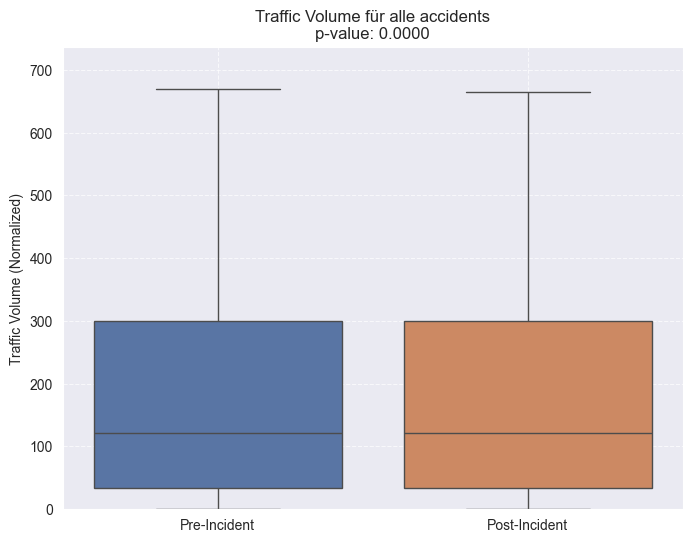

/var/folders/pq/mhr7zllx31730rpvmygzfmc80000gn/T/ipykernel_83429/3923909956.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Period', y='Traffic Volume', data=data_plot, palette=["#4c72b0", "#dd8452"])


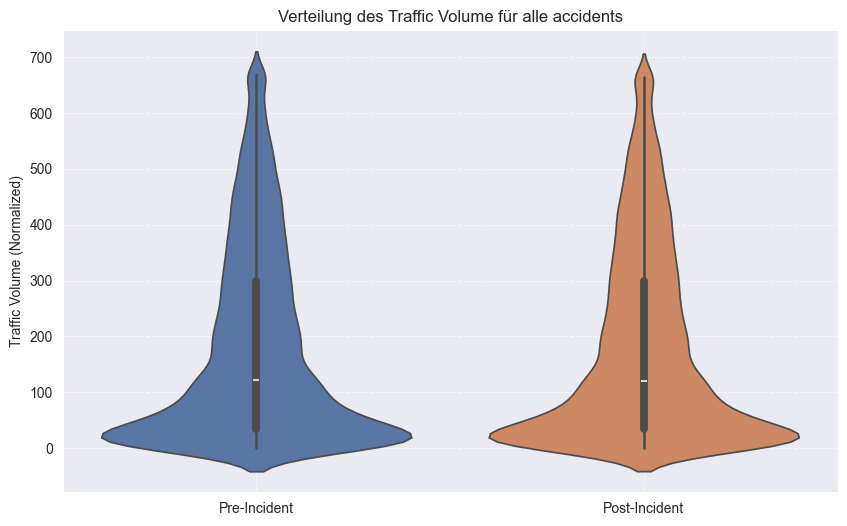

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
import scipy.stats as stats
from datetime import timedelta, datetime
import os
import seaborn as sns

# Pfad und Monatsbezeichnungen
DATA_PATH = '/Users/bugragorkem/Desktop/Uni/5. Semester /Data Science Projekt/archive/p_data/p_einzelnt/'
MONTHS = ["p01", "p02", "p03", "p04", "p05", "p06", "p07", "p08", "p09", "p10", "p11", "p12"]

def find_closest_sensor(incidence_df, sensor_df, max_distance=0.3): 
    # Sortiere die Sensoren nach Freeway und Absolut-PM zur Beschleunigung
    sensor_df = sensor_df.sort_values(by=['Fwy', 'Abs PM'])
    closest_sensors = []
    
    for _, incident in incidence_df.iterrows():
        fwy = incident['Fwy']
        abs_pm = incident['Abs PM']
        
        # Filtere Sensoren des gleichen Freeways und nur vom Typ "HOV"
        matching_sensors = sensor_df[(sensor_df['Fwy'] == fwy) & (sensor_df['Type'] == 'HOV')]
        
        # Finde den zuletzt liegenden Sensor, der innerhalb des maximalen Abstands liegt
        preceding_sensors = matching_sensors[
            (matching_sensors['Abs PM'] <= abs_pm) & 
            (abs_pm - matching_sensors['Abs PM'] <= max_distance)
        ]
        
        if not preceding_sensors.empty:
            closest_sensor = preceding_sensors.iloc[-1]
            closest_sensors.append({
                'Incident_ABS_PM': abs_pm,
                'Incident_Fwy': fwy,
                'station_id': closest_sensor['station_id'], 
                'Sensor_ABS_PM': closest_sensor['Abs PM'],
                'Sensor_Fwy': closest_sensor['Fwy'],
                'time': incident['dt'],
                'Distance': abs_pm - closest_sensor['Abs PM']
            })
    
    return pd.DataFrame(closest_sensors)

def datetime_to_timeslot(dt, month_start):
    """Konvertiert datetime zu Timeslot-Index relativ zum Monatsanfang"""
    delta = dt - month_start
    return int(delta.total_seconds() // 300)

# Lese Unfalldaten ein
incidents = pd.read_csv('/Users/bugragorkem/Desktop/Uni/5. Semester /Data Science Projekt/archive/incidents.csv', 
                         sep="\t", parse_dates=['dt'])
incidents['month'] = incidents['dt'].dt.to_period('M')

# Filtere nur Unfälle mit einer Dauer >= 15 Minuten
incidents = incidents[(incidents['type'] == "accident") & (incidents['Duration (mins)'] >= 15)]

# Lese Sensor-Metadaten ein
sensor_meta = pd.read_csv('/Users/bugragorkem/Desktop/Uni/5. Semester /Data Science Projekt/archive/sensor_meta_feature.csv', 
                          sep="\t")

all_data = []

# Gruppiere die Unfälle nach Monat und verarbeite jeden Monat
for month, month_incidents in incidents.groupby('month'):
    month_str = f"p{month.month:02d}"
    if month_str not in MONTHS:
        continue

    # Versuche, die entsprechenden Monatsdaten zu laden
    try:
        traffic_data = np.load(os.path.join(DATA_PATH, f'{month_str}_car.npy'))
        station_ids = np.load(os.path.join(DATA_PATH, f'{month_str}_car_node.npy')).astype(str)
    except FileNotFoundError:
        print(f"Dateien für {month_str} nicht gefunden")
        continue

    # Bestimme die Sensoren, die zu den Unfällen passen
    closest_sensors = find_closest_sensor(month_incidents, sensor_meta)
    station_to_index = {sid: i for i, sid in enumerate(station_ids)}
    closest_sensors['sensor_index'] = closest_sensors['station_id'].astype(str).map(station_to_index)
    valid_sensors = closest_sensors.dropna(subset=['sensor_index']).copy()

    # Zeitkonvertierung: Ziehe 5 Minuten ab und bestimme den Timeslot relativ zum Monatsanfang
    month_start = datetime(month.year, month.month, 1)
    valid_sensors['time'] = pd.to_datetime(valid_sensors['time'], errors='coerce') - pd.Timedelta(minutes=5)
    valid_sensors['timeslot'] = valid_sensors['time'].apply(lambda x: datetime_to_timeslot(x, month_start))

    time_window = 3  # Anzahl der 5-Minuten-Intervalle vor und nach dem Vorfall
    for _, row in valid_sensors.iterrows():
        idx = int(row['sensor_index'])
        ts = row['timeslot']

        if ts < 0 or ts >= traffic_data.shape[0]:
            continue

        start = max(0, ts - time_window)
        end = min(traffic_data.shape[0], ts + time_window + 1)  # +1, um inklusiv zu schneiden

        if (end - start) < (2 * time_window):
            continue  # Überspringe, falls das Zeitfenster zu klein ist

        traffic_slice = traffic_data[start:end, idx]
        if np.isnan(traffic_slice).any():
            continue  # Überspringe, falls NaNs vorhanden sind

        all_data.append({
            'pre': traffic_slice[:time_window],
            'post': traffic_slice[time_window+1:],  # Zeitpunkt des Vorfalls auslassen
            'feature_names': ['Traffic Volume', 'Occupancy Rate', 'Speed']
        })
    print(f"{month_str} verarbeitet")

# Falls keine gültigen Daten gefunden wurden
if len(all_data) == 0:
    print("Keine gültigen Daten für alle accidents gefunden")
else:
    # Aggregiere die Pre- und Post-Daten aus allen Unfällen
    pre_data = []
    post_data = []
    for entry in all_data:
        pre_data.extend(entry['pre'])
        post_data.extend(entry['post'])
    
    # Optional: Entferne die letzten drei Elemente aus pre_data, falls vorhanden
    if len(pre_data) >= 3:
        pre_data = pre_data[:-3]
    
    # Stelle sicher, dass beide Listen gleich lang sind
    min_length = min(len(pre_data), len(post_data))
    if min_length == 0:
        print("Nicht genügend Daten für alle accidents")
    else:
        # Führe den Wilcoxon-Test durch (alternative='greater')
        stat, p_value = stats.wilcoxon(pre_data[:min_length], post_data[:min_length], alternative='greater')
        median_pre = np.median(pre_data[:min_length])
        median_post = np.median(post_data[:min_length])
        
        print("Ergebnisse für alle accidents:")
        print(f"Wilcoxon statistic: {stat}, p-value: {p_value}")
        print(f"Median Pre-Incident: {median_pre}, Median Post-Incident: {median_post}")
        
        
        # --- Violinplot Visualization ---
        data_plot = pd.DataFrame({
            'Traffic Volume': np.concatenate([pre_data, post_data]),
            'Period': ['Pre-Incident'] * len(pre_data) + ['Post-Incident'] * len(post_data)
        })
        plt.figure(figsize=(10, 6))
        sns.violinplot(x='Period', y='Traffic Volume', data=data_plot, palette=["#4c72b0", "#dd8452"])
        plt.title('Verkehrsaufkommen vor und nach Unfällen')
        plt.xlabel('')
        plt.ylabel('Verkehrsaufkommen')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()


In [ ]:
# Kappe Extremwerte (z. B. 99%-Quantil) und konvertiere in numpy-Arrays
        post_data = np.array(post_data[:min_length])
        post_data = np.clip(post_data, 0, np.percentile(post_data, 99))
        
        # --- Boxplot Visualization ---
        plt.figure(figsize=(8, 6))
        plt.ylim(0, max(pre_data.max(), post_data.max()) * 1.1)  # 10% Puffer hinzufügen
        sns.boxplot(data=[pre_data, post_data], palette=["#4c72b0", "#dd8452"])
        plt.xticks([0, 1], ['Pre-Incident', 'Post-Incident'])
        plt.title(f"Traffic Volume für alle accidents\np-value: {p_value:.4f}")
        plt.ylabel('Traffic Volume (Normalized)')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

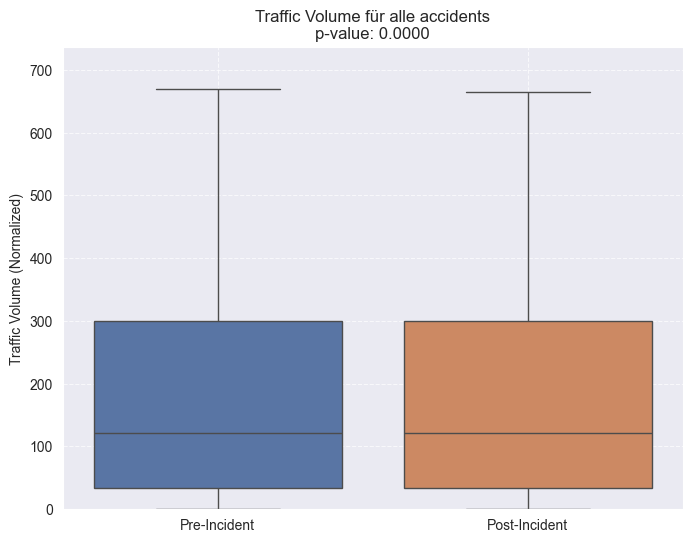

/var/folders/pq/mhr7zllx31730rpvmygzfmc80000gn/T/ipykernel_83429/668220620.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Period', y='Traffic Volume', data=data_plot, palette=["#4c72b0", "#dd8452"])


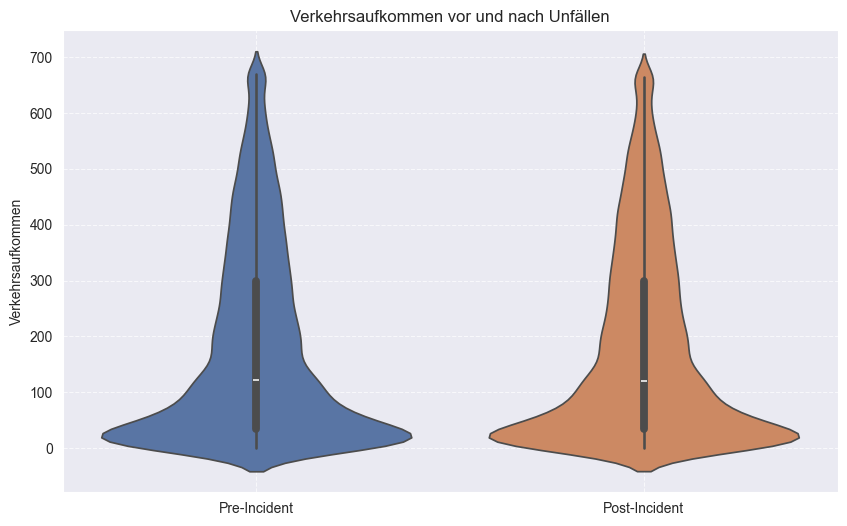

In [20]:
# --- Boxplot Visualization ---
plt.figure(figsize=(8, 6))
plt.ylim(0, max(pre_data.max(), post_data.max()) * 1.1)  # 10% Puffer hinzufügen
sns.boxplot(data=[pre_data, post_data], palette=["#4c72b0", "#dd8452"])
plt.xticks([0, 1], ['Pre-Incident', 'Post-Incident'])
plt.title(f"Traffic Volume für alle accidents\np-value: {p_value:.4f}")
plt.ylabel('Verkehrsaufkommen')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
        
        # --- Violinplot Visualization ---
data_plot = pd.DataFrame({
    'Traffic Volume': np.concatenate([pre_data, post_data]),
    'Period': ['Pre-Incident'] * len(pre_data) + ['Post-Incident'] * len(post_data)
        })
plt.figure(figsize=(10, 6))
sns.violinplot(x='Period', y='Traffic Volume', data=data_plot, palette=["#4c72b0", "#dd8452"])
plt.title('Verkehrsaufkommen vor und nach Unfällen')
plt.xlabel('')
plt.ylabel('Verkehrsaufkommen')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

p01 verarbeitet
p02 verarbeitet
p03 verarbeitet
p04 verarbeitet
p05 verarbeitet
p06 verarbeitet
p07 verarbeitet
p08 verarbeitet
p09 verarbeitet
p10 verarbeitet
p11 verarbeitet
p12 verarbeitet
Ergebnisse für alle accidents:
Wilcoxon statistic: 450012961.0, p-value: 1.1504474045824249e-05
Median Pre-Incident: 122.0, Median Post-Incident: 121.0


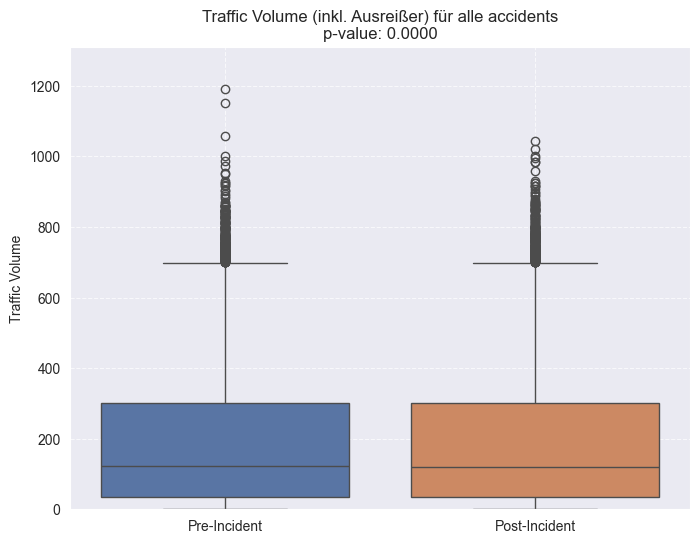

/var/folders/pq/mhr7zllx31730rpvmygzfmc80000gn/T/ipykernel_85720/3603893955.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Period', y='Traffic Volume', data=data_plot, palette=["#4c72b0", "#dd8452"])


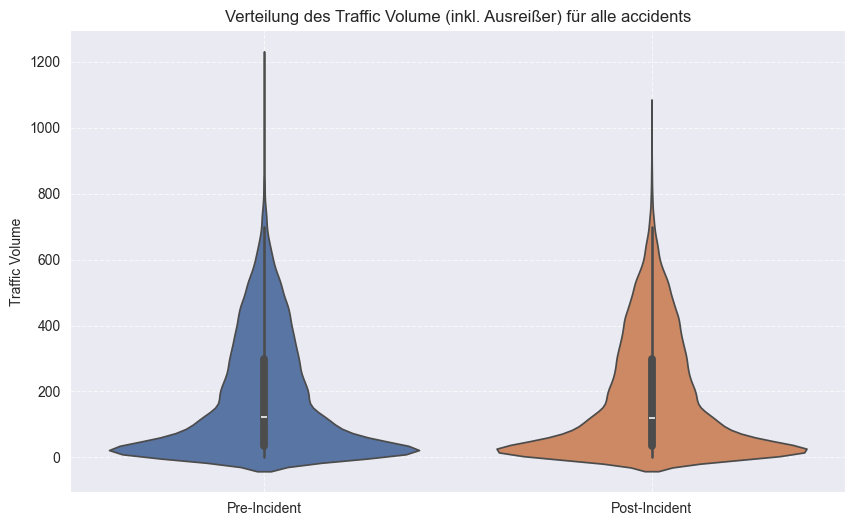

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import timedelta, datetime
import os
import seaborn as sns

# Pfad und Monatsbezeichnungen
DATA_PATH = '/Users/bugragorkem/Desktop/Uni/5. Semester /Data Science Projekt/archive/p_data/p_einzelnt/'
MONTHS = ["p01", "p02", "p03", "p04", "p05", "p06", "p07", "p08", "p09", "p10", "p11", "p12"]

def find_closest_sensor(incidence_df, sensor_df, max_distance=0.3): 
    # Sortiere Sensoren nach Freeway und Absolut-PM
    sensor_df = sensor_df.sort_values(by=['Fwy', 'Abs PM'])
    closest_sensors = []
    for _, incident in incidence_df.iterrows():
        fwy = incident['Fwy']
        abs_pm = incident['Abs PM']
        # Filtere Sensoren des gleichen Freeways und vom Typ "HOV"
        matching_sensors = sensor_df[(sensor_df['Fwy'] == fwy) & (sensor_df['Type'] == 'HOV')]
        # Finde den letzten Sensor, der innerhalb des max. Abstands liegt
        preceding_sensors = matching_sensors[
            (matching_sensors['Abs PM'] <= abs_pm) & 
            (abs_pm - matching_sensors['Abs PM'] <= max_distance)
        ]
        if not preceding_sensors.empty:
            closest_sensor = preceding_sensors.iloc[-1]
            closest_sensors.append({
                'Incident_ABS_PM': abs_pm,
                'Incident_Fwy': fwy,
                'station_id': closest_sensor['station_id'], 
                'Sensor_ABS_PM': closest_sensor['Abs PM'],
                'Sensor_Fwy': closest_sensor['Fwy'],
                'time': incident['dt'],
                'Distance': abs_pm - closest_sensor['Abs PM']
            })
    return pd.DataFrame(closest_sensors)

def datetime_to_timeslot(dt, month_start):
    """Konvertiert datetime zu Timeslot-Index relativ zum Monatsanfang"""
    delta = dt - month_start
    return int(delta.total_seconds() // 300)

# Lese Unfalldaten ein
incidents = pd.read_csv('/Users/bugragorkem/Desktop/Uni/5. Semester /Data Science Projekt/archive/incidents.csv', 
                         sep="\t", parse_dates=['dt'])
incidents['month'] = incidents['dt'].dt.to_period('M')
# Filtere nur Unfälle mit Duration >= 15 Minuten
incidents = incidents[(incidents['type'] == "accident") & (incidents['Duration (mins)'] >= 15)]
sensor_meta = pd.read_csv('/Users/bugragorkem/Desktop/Uni/5. Semester /Data Science Projekt/archive/sensor_meta_feature.csv', sep="\t")

all_data = []

# Verarbeite Unfälle gruppiert nach Monat
for month, month_incidents in incidents.groupby('month'):
    month_str = f"p{month.month:02d}"
    if month_str not in MONTHS:
        continue
    try:
        traffic_data = np.load(os.path.join(DATA_PATH, f'{month_str}_car.npy'))
        station_ids = np.load(os.path.join(DATA_PATH, f'{month_str}_car_node.npy')).astype(str)
    except FileNotFoundError:
        print(f"Dateien für {month_str} nicht gefunden")
        continue

    closest_sensors = find_closest_sensor(month_incidents, sensor_meta)
    station_to_index = {sid: i for i, sid in enumerate(station_ids)}
    closest_sensors['sensor_index'] = closest_sensors['station_id'].astype(str).map(station_to_index)
    valid_sensors = closest_sensors.dropna(subset=['sensor_index']).copy()

    # Zeitkonvertierung: Ziehe 5 Minuten ab und bestimme den Timeslot relativ zum Monatsanfang
    month_start = datetime(month.year, month.month, 1)
    valid_sensors['time'] = pd.to_datetime(valid_sensors['time'], errors='coerce') - pd.Timedelta(minutes=5)
    valid_sensors['timeslot'] = valid_sensors['time'].apply(lambda x: datetime_to_timeslot(x, month_start))

    time_window = 3  # Anzahl der 5-Minuten-Intervalle vor und nach dem Unfall
    for _, row in valid_sensors.iterrows():
        idx = int(row['sensor_index'])
        ts = row['timeslot']

        if ts < 0 or ts >= traffic_data.shape[0]:
            continue

        start = max(0, ts - time_window)
        end = min(traffic_data.shape[0], ts + time_window + 1)  # +1, um inklusiv zu schneiden

        if (end - start) < (2 * time_window):
            continue  # Überspringe, falls das Zeitfenster zu klein ist

        traffic_slice = traffic_data[start:end, idx]
        if np.isnan(traffic_slice).any():
            continue  # Überspringe, falls NaNs vorhanden sind

        all_data.append({
            'pre': traffic_slice[:time_window],
            'post': traffic_slice[time_window+1:],  # Unfallzeitpunkt überspringen
            'feature_names': ['Traffic Volume', 'Occupancy Rate', 'Speed']
        })
    print(f"{month_str} verarbeitet")

if len(all_data) == 0:
    print("Keine gültigen Daten für alle accidents gefunden")
else:
    pre_data = []
    post_data = []
    for entry in all_data:
        pre_data.extend(entry['pre'])
        post_data.extend(entry['post'])
    
    # Optional: Entferne die letzten drei Elemente aus pre_data, falls vorhanden
    if len(pre_data) >= 3:
        pre_data = pre_data[:-3]
    
    min_length = min(len(pre_data), len(post_data))
    if min_length == 0:
        print("Nicht genügend Daten für alle accidents")
    else:
        # Wilcoxon-Test (alternative='greater')
        stat, p_value = stats.wilcoxon(pre_data[:min_length], post_data[:min_length], alternative='greater')
        median_pre = np.median(pre_data[:min_length])
        median_post = np.median(post_data[:min_length])
        
        print("Ergebnisse für alle accidents:")
        print(f"Wilcoxon statistic: {stat}, p-value: {p_value}")
        print(f"Median Pre-Incident: {median_pre}, Median Post-Incident: {median_post}")
        
        # Konvertiere in numpy-Arrays (keine np.clip, um Ausreißer beizubehalten)
        pre_data = np.array(pre_data[:min_length])
        post_data = np.array(post_data[:min_length])
        
        # --- Boxplot Visualization ---
        plt.figure(figsize=(8, 6))
        plt.ylim(0, max(pre_data.max(), post_data.max()) * 1.1)  # 10% Puffer
        sns.boxplot(data=[pre_data, post_data], palette=["#4c72b0", "#dd8452"])
        plt.xticks([0, 1], ['Pre-Incident', 'Post-Incident'])
        plt.title(f"Traffic Volume (inkl. Ausreißer) für alle accidents\np-value: {p_value:.4f}")
        plt.ylabel('Traffic Volume')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()
        
        # --- Violinplot Visualization ---
        data_plot = pd.DataFrame({
            'Traffic Volume': np.concatenate([pre_data, post_data]),
            'Period': ['Pre-Incident'] * len(pre_data) + ['Post-Incident'] * len(post_data)
        })
        plt.figure(figsize=(10, 6))
        sns.violinplot(x='Period', y='Traffic Volume', data=data_plot, palette=["#4c72b0", "#dd8452"])
        plt.title('Verteilung des Traffic Volume (inkl. Ausreißer) für alle accidents')
        plt.xlabel('')
        plt.ylabel('Traffic Volume')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()
